### EX1

In [5]:
import numpy as np


class GMM:
    def __init__(self,
                 n_components,
                 means=None,
                 covariances=None,
                 mixing_probs=None,
                 epsilon=1e-6,
                 callback = None):
        
        self.n_components = n_components
        self.means = means
        self.covariances = covariances
        self.mixing_probs = mixing_probs
        self.epsilon = epsilon
        self.__callback = callback

    def fit(self, features):
        # Initialise
        n, _ = features.shape
        norm_densities = np.empty((n, self.n_components), np.float)
        responsibilities = np.empty((n, self.n_components), np.float)
        old_log_likelihood = 0
        self._initialise_parameters(features)

        while True:
            # Compute normal densities
            for i in np.arange(n):
                x = features[i]

                for j in np.arange(self.n_components):
                    norm_densities[i][j] = self.multivariate_normal_pdf(x, self.means[j], self.covariances[j])

            # Estimate log likelihood
            log_vector = np.log(np.array([np.dot(self.mixing_probs.T, norm_densities[i]) for i in np.arange(n)]))
            log_likelihood = np.dot(log_vector.T, np.ones(n))
            
            self.call_back()

            # Check for convergence
            if np.absolute(log_likelihood - old_log_likelihood) < self.epsilon:
                break

            # E-step: evaluate responsibilities
            for i in np.arange(n):
                x = features[i]
                denominator = np.dot(self.mixing_probs.T, norm_densities[i])
                for j in np.arange(self.n_components):
                    responsibilities[i][j] = self.mixing_probs[j] * norm_densities[i][j] / denominator

            # M-step: re-estimate the parameters
            for i in np.arange(self.n_components):
                responsibility = (responsibilities.T)[i]

                # Common denominator
                denominator = np.dot(responsibility.T, np.ones(n))

                # Update mean
                self.means[i] = np.dot(responsibility.T, features) / denominator

                # Update covariance
                difference = features - np.tile(self.means[i], (n, 1))
                self.covariances[i] = np.dot(np.multiply(responsibility.reshape(n,1), difference).T, difference) / denominator

                # Update mixing probabilities
                self.mixing_probs[i] = denominator / n

            old_log_likelihood = log_likelihood

    def cluster(self, features):
        # Initialise
        n, _ = features.shape
        partition = np.empty(n, np.int)
        distances = np.empty(self.n_components, np.float)
        cov_inverses = [np.linalg.inv(cov) for cov in self.covariances]

        # Assign each feature point to a Gaussian distribution
        for i in np.arange(n):
            x = features[i]

            # Compute Mahanalobis distances from each mixture
            for j in np.arange(self.n_components):
                distances[j] = np.dot(np.dot((x - self.means[j]).T, cov_inverses[j]), x - self.means[j])

            # Find index of the minimum distance, and assign to a cluster
            partition[i] = np.argmin(distances)

        return partition

    def call_back(self):
        if self.__callback:
            dct = {
                'mixing_probs': self.mixing_probs,
                'means': self.means,
                'covariances': self.covariances
            }
            self.__callback(dct)

    def multivariate_normal_pdf(self, x, mean, covariance):
        centered = x - mean
        cov_inverse = np.linalg.inv(covariance)
        cov_det = np.linalg.det(covariance)
        exponent = np.dot(np.dot(centered.T, cov_inverse), centered)
        return np.exp(-0.5 * exponent) / np.sqrt(cov_det * np.power(2 * np.pi, self.n_components))

    def _initialise_parameters(self, features):
        if not self.means or not self.covariances:
            n, m = features.shape

            # Shuffle features set
            indices = np.arange(n)
            np.random.shuffle(np.arange(n))
            features_shuffled = np.array([features[i] for i in indices])

            # Split into n_components subarrays
            divs = int(np.floor(n / self.n_components))
            features_split = [features_shuffled[i:i+divs] for i in range(0, n, divs)]

            # Estimate means/covariances (or both)
            if not self.means:
                means = []
                for i in np.arange(self.n_components):
                    means.append(np.mean(features_split[i], axis=0))
                self.means = np.array(means)

            if not self.covariances:
                covariances = []
                for i in np.arange(self.n_components):
                    covariances.append(np.cov(features_split[i].T))
                self.covariances = np.array(covariances)

        if not self.mixing_probs:
            self.mixing_probs = np.repeat(1 / self.n_components, self.n_components)

### Ex2

In [8]:
# Create three toy datasets
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples= 100,
                    n_features= 2,
                    centers= 3,
                    shuffle=True, 
                    random_state=40)

print("Features:\n", X[:5])
print("Target:\n", y[:5])

Features:
 [[-2.94305724 -4.56159935]
 [-1.30337776 -8.9771589 ]
 [-0.13511804 -3.15334516]
 [ 2.88970296 -4.26961959]
 [ 4.18260704 -5.1819068 ]]
Target:
 [2 0 2 1 1]


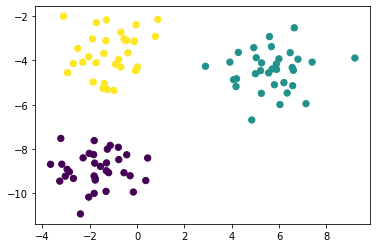

In [13]:
from sklearn import mixture
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=3).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [14]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.    1.   ]
 [1.    0.    0.   ]
 [0.    0.    1.   ]
 [0.    0.997 0.003]
 [0.    1.    0.   ]]


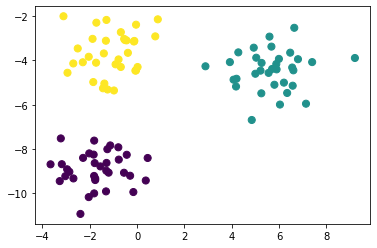

In [15]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [18]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

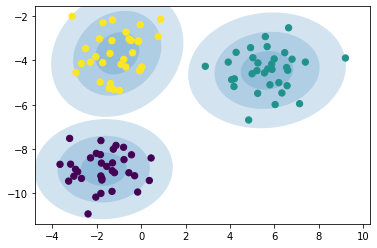

In [19]:
gmm = GMM(n_components=3, random_state=42)
plot_gmm(gmm, X)

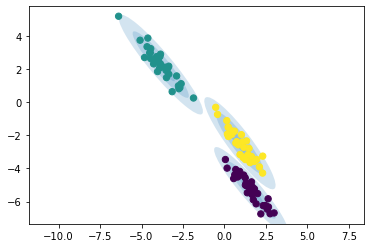

In [22]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))
gmm = GMM(n_components=3, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

### Ex3